## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [ ]:
import os
import sys
import random
import math
import re
import time
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image, ImageDraw

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/AML_PROJECT")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs/bdd100k")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/anaconda3/envs/mask

## Configurations

In [ ]:
# MS COCO Dataset
import bdd100k
config = bdd100k.Bdd100kConfig()
COCO_DIR = '/content/drive/MyDrive/AML_PROJECT/datasets/bdd100k/'


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  720
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [ ]:
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  720
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Notebook Preferences

In [ ]:
DEVICE = "/gpu:0"

TEST_MODE = "inference"

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
# @title Load Validation Data
dataset = bdd100k.Bdd100kDataset()
dataset.load_bdd100k('/content/drive/MyDrive/AML_PROJECT/datasets/bdd100k/val/ins_seg_val_cocofmt.json', '/content/drive/MyDrive/AML_PROJECT/datasets/bdd100k/val')

dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

100%|██████████| 1000/1000 [00:00<00:00, 131219.62it/s]

Images: 1000
Classes: ['BG', 'pedestrian', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']


## Load Model

In [ ]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
weights_path = model.find_last()

print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Loading weights  /home/ec2-user/SageMaker/Mask_RCNN/logs/bdd100k/bdd100k20220307T2011/mask_rcnn_bdd100k_0008.h5


2022-03-09 21:38:13.852652: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-03-09 21:38:13.883834: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2499995000 Hz
2022-03-09 21:38:13.889699: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5572ac663a60 executing computations on platform Host. Devices:
2022-03-09 21:38:13.889725: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2022-03-09 21:38:15.479999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 21:38:15.557966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so r

Re-starting from epoch 8


## Run Detection

image ID: bdd100k.951 (950) 951
Processing 1 images
image                    shape: (1280, 1280, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32
gt_class_id              shape: (42,)                 min:    1.00000  max:    5.00000  int32
gt_bbox                  shape: (42, 4)               min:    0.00000  max: 1279.00000  int32
gt_mask                  shape: (1280, 1280, 42)      min:    0.00000  max:    1.00000  bool


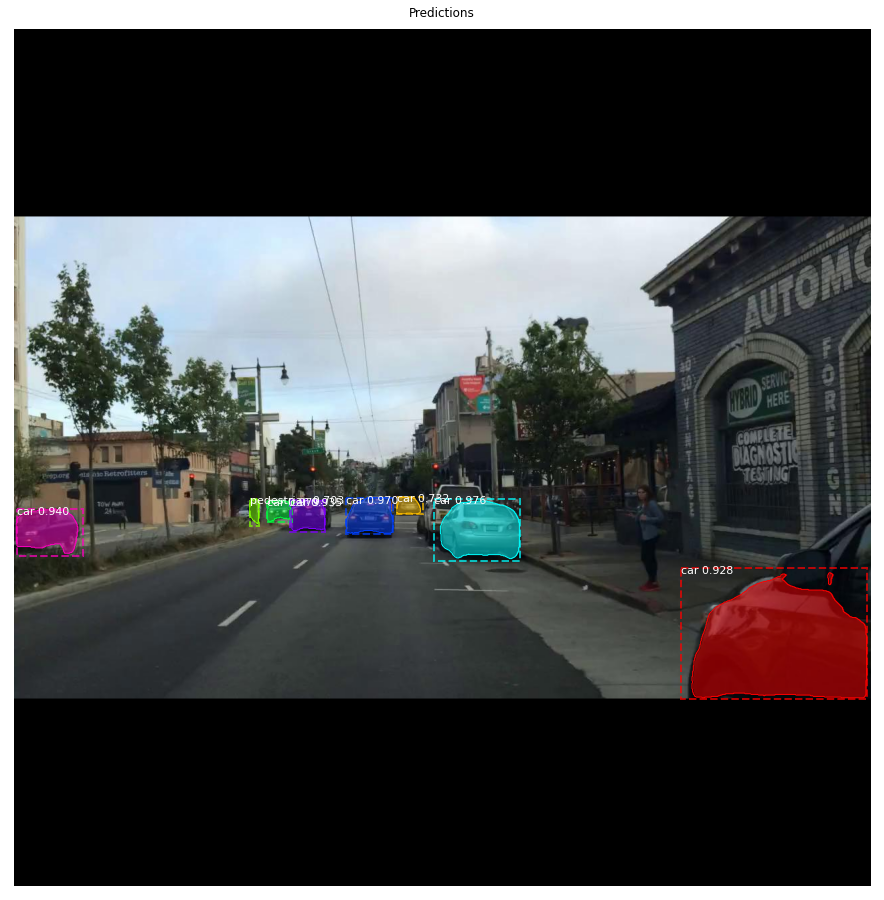

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Compute mAP @ IoU=50 on Batch of Images

In [ ]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 200)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

 mAP @ IoU=50:  0.4924295724611795 


In [ ]:
# @title Load Test Data
dataset = bdd100k.Bdd100kDataset()
dataset.load_bdd100k('/content/drive/MyDrive/AML_PROJECT/datasets/bdd100k/val/ins_seg_val_cocofmt.json', '/content/drive/MyDrive/AML_PROJECT/datasets/bdd100k/test')

dataset.prepare()

### Precision-Recall

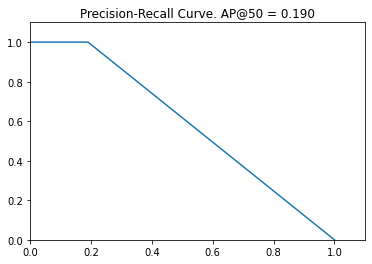

In [ ]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5

image_ids = np.random.choice(dataset.image_ids, 200)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

print("mAP: ", np.mean(APs))

mAP:  0.55051165881717595


Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


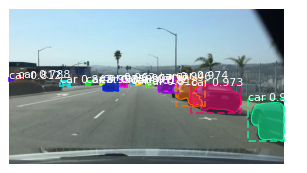

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


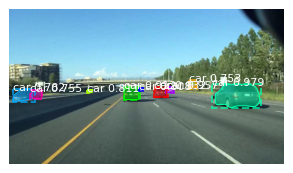

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


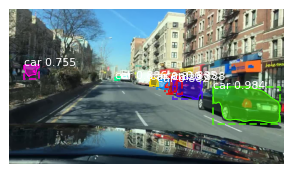

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


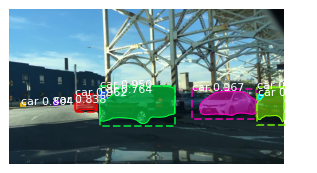

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


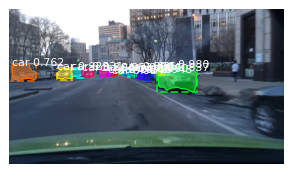

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


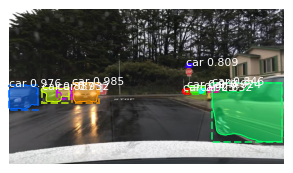

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


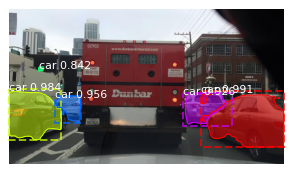

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


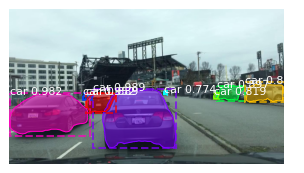

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


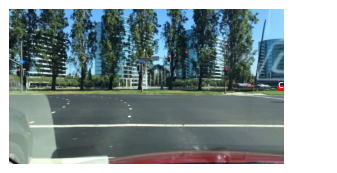

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


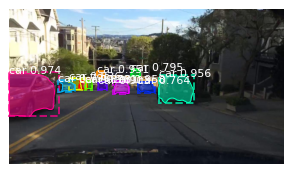

In [ ]:
import skimage


real_test_dir = '/content/drive/MyDrive/AML_PROJECT/datasets/bdd100k/test/'
image_paths = []
for filename in np.random.choice(os.listdir(real_test_dir), 10, replace=False):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                dataset_val.class_names, r['scores'], figsize=(5,5))